# Generate nam (Bigram)
A fun little project, to generate words automatically

Based and fully inspired on [https://github.com/karpathy/makemore](https://github.com/karpathy/makemore)

Just for learning pourposes


It's split in two sections. Each section is a different way of approaching the same problem.

In [1]:
!pip install torch
!pip install matplotlib
!wget https://gist.githubusercontent.com/craigmartin97/e98a9e2a267c379e47be1191d9431de2/raw/c09c7356e85e39e41faa92a665b7ef0b3b840b6a/last-names.txt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://gist.githubusercontent]87Saving 'last-names.txt.5'
87last-names.txt.5     100% [=============================>]  679.12K    --.-KB/s87HTTP response 200  [https://gist.githubusercontent.com/craigmartin97/e98a9e2a267c379e47be1191d9431de2/raw/c09c7356e85e39e41faa92a665b7ef0b3b840b6a/last-names.txt]
87last-names.txt.5     100% [=============================>]  679.12K    --.-KB/s87[Files: 1  Bytes: 679.12K [704.]8

In [2]:
import numpy as np
import torch

## Create and prepare the dataset

In [3]:
text = open("last-names.txt").read()
raw_names = text.splitlines()
raw_names = ["." + name + "." for name in raw_names]
vocab = sorted(list(set(text + ".")))
raw_names[:10]

['.SMITH.',
 '.JOHNSON.',
 '.WILLIAMS.',
 '.JONES.',
 '.BROWN.',
 '.DAVIS.',
 '.MILLER.',
 '.WILSON.',
 '.MOORE.',
 '.TAYLOR.']

In [4]:
itc = dict(list(enumerate(vocab)))
cti = {v: k for k, v in itc.items()}
itc


{0: '\n',
 1: '.',
 2: 'A',
 3: 'B',
 4: 'C',
 5: 'D',
 6: 'E',
 7: 'F',
 8: 'G',
 9: 'H',
 10: 'I',
 11: 'J',
 12: 'K',
 13: 'L',
 14: 'M',
 15: 'N',
 16: 'O',
 17: 'P',
 18: 'Q',
 19: 'R',
 20: 'S',
 21: 'T',
 22: 'U',
 23: 'V',
 24: 'W',
 25: 'X',
 26: 'Y',
 27: 'Z'}

In [5]:
names = [list(name) for name in raw_names]
tokens = [[cti[token] for token in name] for name in names]
pairs = []
for name in tokens:
    pairs.extend(list(zip(name, name[1:])))
X = [pair[0] for pair in pairs]
labels = [pair[1] for pair in pairs]

In [6]:
from collections import Counter
counter = Counter(pairs)

28


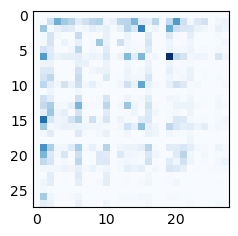

In [7]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots()

canvas = np.zeros((len(itc), len(itc)))
print(len(itc))

for key, value in counter.items():
    canvas[key[0],key[1]] = value
ax.imshow(canvas)


## Create pair probability matrix (canvas)

In [8]:
mat = torch.tensor(canvas)
mat += 1
sums = mat.sum(1).unsqueeze(-1)
mat = mat / sums

In [20]:
last = 1
loss = 0
ix = 0
out = ""
while True:
    y = torch.multinomial(mat[last, :], num_samples=1, replacement=True)
    # y = torch.rand(1) * len(itc) // 1
    prob = mat[last, y]
    loss += torch.log(prob)
    last = int(y.item())
    
    if y == 1:
        break
    ix += 1

    out += itc[last]
mat[1, y]
loss /= -ix
print(f"{loss=}")
print(f"{out=}")

loss=tensor([2.9193], dtype=torch.float64)
out='ROSAWAWSESKSHARINTTLSAIEKIT'


## Now with ML
Now the same thing, but instead of generating the pair probability matrix manually, lets learn it

In [10]:
import torch.nn.functional as F
num = 200000
X = torch.tensor(X[:num])
y = torch.tensor(labels[:num])
print(X.shape)
W = torch.randn((len(itc), len(itc)), requires_grad=True)

for i in range(100):
    xenc = F.one_hot(torch.tensor(X),len(itc)) / 1.0
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    nll = -probs[torch.arange(num), y].log().mean()
    W.grad = None
    nll.backward()    
    W.data -= W.grad * 50
    if i % 5 == 0:
        print(nll.item())



torch.Size([200000])


/tmp/ipykernel_46346/3294076015.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(X),len(itc)) / 1.0


3.8274340629577637
2.9393484592437744
2.759223699569702
2.6847751140594482
2.6437957286834717
2.618095636367798
2.601090431213379
2.5893406867980957
2.58079195022583
2.574251174926758
2.569049596786499
2.5647997856140137
2.5612595081329346
2.5582680702209473
2.5557096004486084
2.553499221801758
2.5515713691711426
2.5498764514923096
2.548375129699707
2.547037124633789


Text(0.5, 1.0, 'Manual matrix')

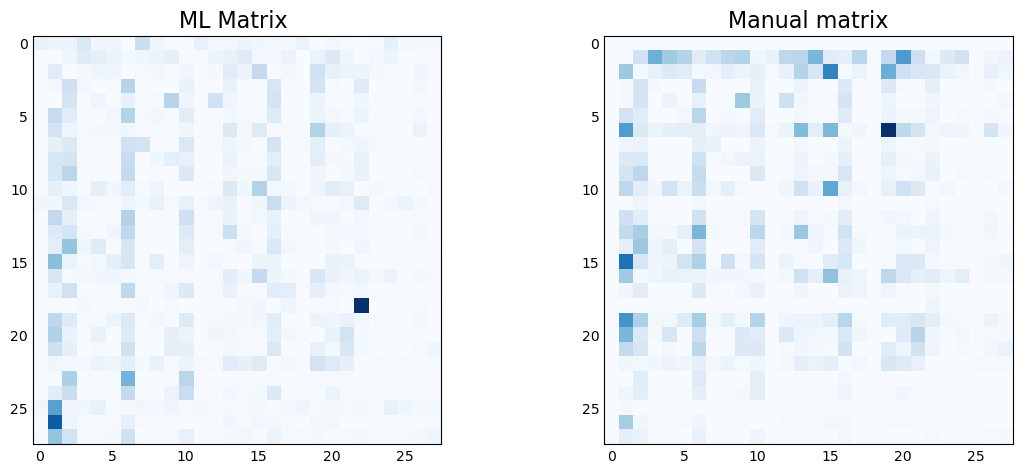

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 6))

W_norm = W.exp() / W.exp().sum(1,keepdims=True)
plt.subplots_adjust(wspace=0.4) 
ax[0].imshow(W_norm.detach().numpy())
ax[0].set_title("ML Matrix ", fontsize=16)

ax[1].imshow(canvas)
ax[1].set_title("Manual matrix", fontsize=16)


The results we get with ML. We can see that the results are almost the same as the ones generated with the manual matrix

If we trained for longer, the learned matrix would be basically equivalent

Here are some words generated by the ML matrix:

In [12]:
last = 1
loss = 0
ix = 0
out = ""
while True:
    xenc = F.one_hot(torch.tensor([last]),len(itc)) / 1.0
    y = xenc @ W
    s = F.softmax(y, 1)
    y = torch.multinomial(s[0], num_samples=1, replacement=True)
    # y = torch.rand(1) * len(itc) // 1
    #prob = mat[last, y]
    #loss += torch.log(prob)
    last = int(y.item())

    if y == 1:
        break
    ix += 1
    out += itc[last]
mat[1, y]
#loss /= -ix
print(f"{out=}")


out='QUNEERNTOBECE'
